- copied from https://www.kaggle.com/ksishawon/segnet-dstl

In [37]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import datetime
import matplotlib.pyplot as plt
from shapely.wkt import loads as wkt_loads
import tifffile as tiff

from keras import backend as K
# from sklearn.metrics import jaccard_similarity_score

from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import tensorflow as tf
from collections import defaultdict
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import gc
import warnings
import zipfile
warnings.filterwarnings("ignore")
from keras.models import load_model


import sys 
sys.path.insert(0, '../')
import random as rn
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tqdm import tqdm

ImportError: cannot import name 'Adam' from 'keras.optimizers' (/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/kaggle-eye-in-the-sky-PHbCW2TA-py3.9/lib/python3.9/site-packages/keras/optimizers.py)

In [6]:
os.mkdir('../kaggle/data')
os.mkdir('../kaggle/msk')
os.mkdir('../kaggle/model_weights')
os.mkdir('../kaggle/subm')
os.mkdir('../kaggle/x_tr_a')
os.mkdir('../kaggle/x_tr_na')
os.mkdir('../kaggle/y_tr_a')
os.mkdir('../kaggle/y_tr_na')

os.mkdir('../kaggle/x_val_a')
os.mkdir('../kaggle/x_val_na')
os.mkdir('../kaggle/y_val_a')
os.mkdir('../kaggle/y_val_na')

os.mkdir('../kaggle/x_test_a')
os.mkdir('../kaggle/x_test_na')
os.mkdir('../kaggle/y_test_a')
os.mkdir('../kaggle/y_test_na')

- read in data

In [8]:
num_cls = 10
size = 160
smooth = 1e-12
inDir = '../data'
TR = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)

#SF = pd.read_csv('/content/sample_submission.csv')
GS = GS.rename( columns={'Unnamed: 0':'ImageId'}) #rename 'ImageId'

- preprocessing

In [9]:
#https://www.kaggle.com/aamaia/rgb-using-m-bands-example

# "Contrast enhancement", similar to the default when opening an image using QGIS.

def adjust_contrast(bands, lower_percent=2, higher_percent=98):
    """
    to adjust the contrast of the image 
    bands is the image 
    """
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)

In [10]:
def coordi_to_raster(coords, img_size, xmax, ymax):
    """
    converts coordinates(polygons) to raster(pixels).
    """
  
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / xmax
    yf = H1 / ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

def convert_contours(polygonList, raster_img_size, xmax, ymax):
    """
    Returns exterior and interior coords of the given multipolygon,
    which are then used to create image masks with multipolygon objects.
    """
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = coordi_to_raster(perim, raster_img_size, xmax, ymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = coordi_to_raster(interior, raster_img_size, xmax, ymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def generate_mask_for_image_and_class(raster_size, image_id, class_type):

    """
    returns generated image_mask using img_size(raster_size), image_id and class_type.
    """
    xmax, ymax = GS[GS.ImageId == image_id].iloc[0, 1:].astype(float)

    df_image = TR[TR.ImageId == image_id]
    multipoly_def = df_image[df_image.ClassType == class_type].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    
    contours = convert_contours(polygonList, raster_size, xmax, ymax)

    img_mask = np.zeros(raster_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, 1)
    cv2.fillPoly(img_mask, interior_list, 0)

    return img_mask

In [54]:
TR.iloc[10].MultipolygonWKT[:100]

'MULTIPOLYGON (((0.000439 -0.009039999999999999, 0.000438 -0.008999, 0.000637 -0.008985999999999999, '

In [55]:
polygonList = wkt_loads(TR.iloc[10].MultipolygonWKT)

In [ ]:
polygonList.

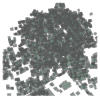

In [56]:
polygonList # interesting this gives us a list of the polygons in the image.

In [19]:
def get_patches(img, msk, name1, name2, name3, name4, amt, aug=True):

    """
    returns image pathces(crops) of given image and mask
    patch_size = 160*160
    """

    random.seed(42)
    is2 = int(1.0 * size)

    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    a, b , c, d = [], [], [], []

    # thresholds for each class to get patches
    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    
    xyz = np.ceil(amt*0.10).astype(int)
    amt1 = amt-xyz
    amt2 = xyz

   # to get augmented data
    for i in range(amt1):

        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

     
        for j in range(num_cls):
            sm = np.sum(ms[:, :, j])

            if 1.0 * sm / is2 ** 2 > tr[j]:
               
                #augmentation
                if aug:
                    
                    # reversing
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]

                    #flipping 
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]
                    rotation = np.random.randint(4) # 0, 1, 2, 3

                    #transpose & rotation
                    if random.uniform(0, 1) > 0.5:
                       im = np.rot90(im.transpose((1,0,2)), k=rotation)
                       ms = np.rot90(ms.transpose((1,0,2)), k=rotation)
                    
                    #rotation
                    if random.uniform(0, 1) > 0.5:
                      im = np.rot90(im, k=rotation)
                      ms = np.rot90(ms, k=rotation)
                    
                    #shearing 
                    if random.uniform(0, 1) > 0.5:
                       im = tf.keras.preprocessing.image.apply_affine_transform(im, shear=0)
                       im = tf.keras.preprocessing.image.apply_affine_transform(im, shear=0)
                                     
                
                im = im.astype(np.float16)
                ms = ms.astype(np.float16)
                
                
                np.save("../kaggle/{}/{}".format(name1, i),im)  
                np.save("../kaggle/{}/{}".format(name2, i),ms)  
               
                a.append("../kaggle/{}/{}.npy".format(name1, i))
                b.append("../kaggle/{}/{}.npy".format(name2, i))

    # to get non-augmented data
    for i in range(amt2):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        im = im.astype(np.float16)
        ms = ms.astype(np.float16)
                                  
        np.save("../kaggle/{}/{}".format(name3, i),im)  
        np.save("../kaggle/{}/{}".format(name4, i),ms)  
                
        c.append("../kaggle/{}/{}.npy".format(name3, i))
        d.append("../kaggle/{}/{}.npy".format(name4, i))

    
    print(len(a), len(b))
    print(len(c), len(d))
  
    return a+c, b+d

In [17]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        #print(len(batch))
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size

class Dataset:
  
    def __init__(self, images_dir, mask_dir):
        
        self.ids = images_dir
        self.images_fps = images_dir
        self.masks_fps  = mask_dir
    
    def __getitem__(self, i):
        
        # read data
        image = np.load(self.images_fps[i]) 
        mask  = np.load(self.masks_fps[i])

          
        image = np.stack(image, axis=-1).astype('float')
        mask = np.stack(mask, axis=-1).astype('float')

        #image = np.transpose(image, (1,0,2)) 
        #mask = np.transpose(mask, (1,0,2)) 
    
        image = np.transpose(image, (0,2,1)) 
        mask = np.transpose(mask, (0,2,1)) 
  
        return image, mask
      
    def __len__(self):
        return len(self.ids)
    

In [14]:
def M(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    zip_path = '../data/sixteen_band.zip'
    tgtImg = '{}_M.tif'.format(image_id)
    with zipfile.ZipFile(zip_path) as myzip:
        files_in_zip = myzip.namelist()
        for fname in files_in_zip:
            if fname.endswith(tgtImg):
                with myzip.open(fname) as myfile:
                    img = tiff.imread(myfile)
                    img = np.rollaxis(img, 0, 3)
                    return img
                
                

print ("let's combine all imgs together")
s = 835

X = np.zeros((5 * s, 5 * s, 8))
Y = np.zeros((5 * s, 5 * s, num_cls))  

ids = sorted(set(TR.ImageId))
print (len(ids))

for i in range(5):
    for j in range(5):
        id = ids[5 * i + j]

        rgb_img = M(id)
        img = adjust_contrast(rgb_img).copy()
        
        
        print (img.shape, id)
        X[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
        for z in range(num_cls):
            Y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

np.save('../kaggle/data/X', X)
np.save('../kaggle/data/Y', Y)
print(X.shape)
print(Y.shape)

let's combine all imgs together
25
(837, 849, 8) 6010_1_2
(837, 849, 8) 6010_4_2
(837, 848, 8) 6010_4_4
(837, 848, 8) 6040_1_0
(837, 848, 8) 6040_1_3
(837, 848, 8) 6040_2_2
(837, 846, 8) 6040_4_4
(837, 851, 8) 6060_2_3
(838, 835, 8) 6070_2_3
(837, 848, 8) 6090_2_0
(837, 848, 8) 6100_1_3
(837, 848, 8) 6100_2_2
(837, 848, 8) 6100_2_3
(837, 849, 8) 6110_1_2
(837, 849, 8) 6110_3_1
(837, 849, 8) 6110_4_0
(837, 851, 8) 6120_2_0
(837, 851, 8) 6120_2_2
(837, 849, 8) 6140_1_2
(837, 849, 8) 6140_3_1
(837, 851, 8) 6150_2_3
(837, 848, 8) 6160_2_1
(837, 848, 8) 6170_0_4
(837, 848, 8) 6170_2_4
(837, 848, 8) 6170_4_1
(4175, 4175, 8)
(4175, 4175, 10)


- split data into train/val/test

In [20]:
x_trn, y_trn = get_patches(X, Y, 'x_tr_a', 'y_tr_a', 'x_tr_na', 'y_tr_na', 20000, aug=True)

6262 6262
2000 2000


In [21]:
x_val, y_val = get_patches(X, Y, 'x_val_a', 'y_val_a', 'x_val_na', 'y_val_na', 4000, aug=True)

1246 1246
400 400


In [22]:
x_test, y_test = get_patches(X, Y, 'x_test_a', 'y_test_na', 'x_test_a', 'y_test_na', 4000, aug=True)

1246 1246
400 400


In [61]:
x_trn[0]

'../kaggle/x_tr_a/0.npy'

In [63]:
image, mask = train_dataset.__getitem__(1)

In [65]:
image.shape

(160, 160, 8)

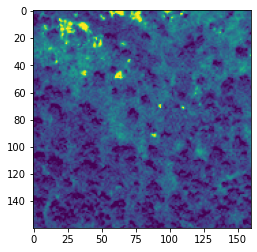

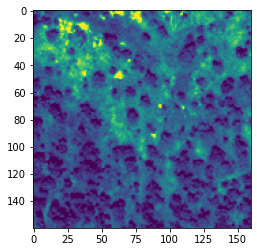

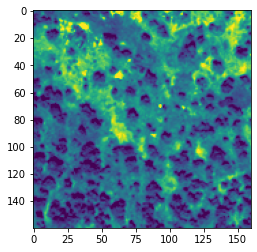

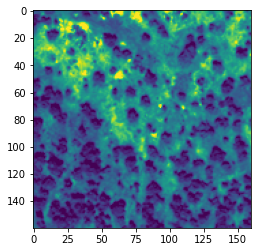

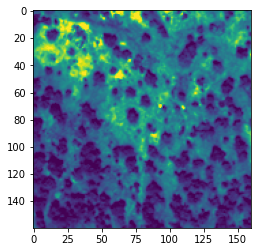

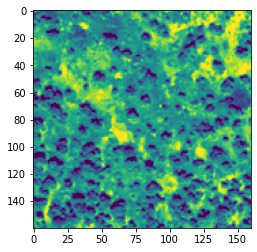

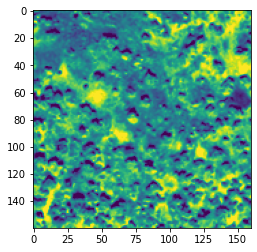

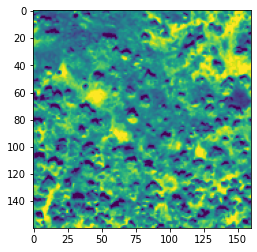

In [80]:
# train image

for  i in range(image.shape[2]):
    plt.imshow( image[:,:,i])
    plt.show()

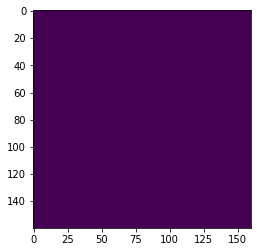

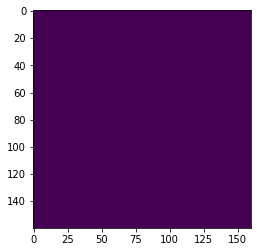

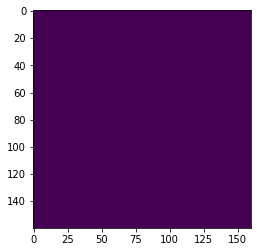

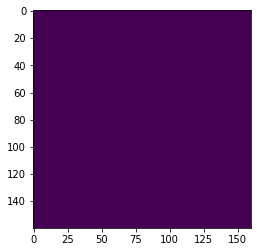

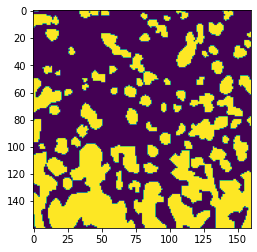

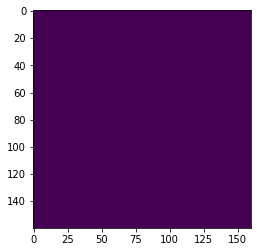

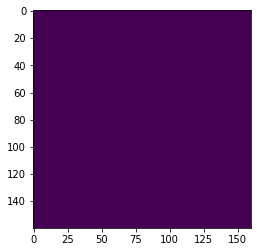

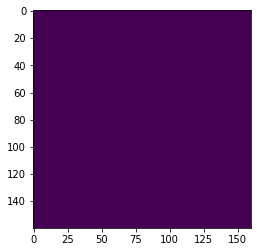

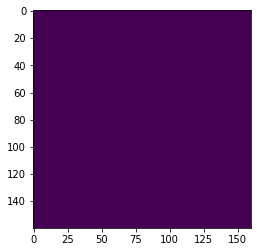

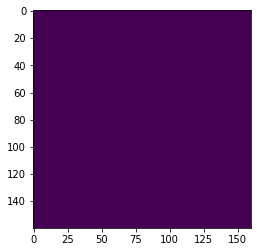

In [81]:
# train image

for  i in range(mask.shape[2]):
    plt.imshow( mask[:,:,i])
    plt.show()

In [23]:
train_dataset = Dataset(x_trn, y_trn)
train_dataloader = Dataloder(train_dataset, batch_size=8)
val_dataset = Dataset(x_val, y_val)
val_dataloader = Dataloder(val_dataset, batch_size=8)

In [24]:
train_dataloader[0][0].shape


(8, 160, 160, 8)

## Modeling

In [25]:
def jaccard_coef(y_true, y_pred):
    """
    Jaccard Index: Intersection over Union.
    J(A,B) = |A∩B| / |A∪B| 
         = |A∩B| / |A|+|B|-|A∩B|
    """
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    total = K.sum(y_true + y_pred, axis=[0, -1, -2])
    union = total - intersection

    jac = (intersection + smooth) / (union+ smooth)

    return K.mean(jac)

In [38]:
##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
rn.seed(12)

def SegNet():
    
    tf.random.set_seed(32)
    classes= 10
    img_input = Input(shape=(size, size, 8))
    x = img_input

    # Encoder 
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 23))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',  kernel_initializer = tf.keras.initializers.he_normal(seed= 43))(x)
   # x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 32))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 41))(x)
   # x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 33))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Dropout(0.5)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 35))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 54))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 39))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    #Decoder
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 45))(x)
   # x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 41))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 49))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
      
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 18))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 21))(x)
    x = BatchNormalization()(x)
    x = Conv2D(classes, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 16))(x)
    x = Dropout(0.25)(x)
  
    x = Activation("softmax")(x)
    
    model = Model(img_input, x)
  
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[jaccard_coef])
    return model

In [39]:
def changeLearningRate(epoch):

    #lr=0.001
    lr=0.0001
    if epoch > 10 and epoch <=20:
      lr*=0.1
    elif epoch > 20 and epoch <=30:
      lr*=0.01
    elif epoch > 30 and epoch <=40:
      lr*=0.001
    elif epoch > 40 and epoch <=50:  
      lr*=0.0001
    elif epoch > 50 and epoch <=60:  
      lr*=0.0001  
    elif epoch > 60:
      lr*=0.0001

    return lr

In [40]:
#https://towardsdatascience.com/neural-network-with-tensorflow-how-to-stop-training-using-callback-5c8d575c18a9

ACCURACY_THRESHOLD=0.502
class myCallback(tf.keras.callbacks.Callback): 
    
    def on_epoch_end(self, epoch, logs={}): 
        if (logs.get('val_jaccard_coef') > ACCURACY_THRESHOLD) and (logs.get('jaccard_coef') > ACCURACY_THRESHOLD):   #and ((logs.get('accuracy')-logs.get('val_accuracy'))<=5):
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
          self.model.stop_training = True

stop = myCallback()

In [41]:
filepath="../kaggle/model_weights/weights-{epoch:02d}-{val_jaccard_coef:.4f}.hdf5"

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

In [42]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose = 1, min_delta = 0.0001)
lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)
#call_list = [checkpoint, lrschedule, rlrop, stop]

In [43]:
model = SegNet()

In [44]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 8)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 160, 160, 64)      4672      
                                                                 
 batch_normalization_10 (Bat  (None, 160, 160, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 160, 160, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 80, 80, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 80, 80, 64)        0   

In [48]:
train_dataloader.__getitem__(0)

2

In [45]:
history = model.fit(train_dataloader, 
                              steps_per_epoch=len(train_dataloader),
                              epochs=2,
                              validation_data=val_dataloader, 
                              callbacks=checkpoint
                              )

Epoch 1/2
  47/1032 [>.............................] - ETA: 1:05:29 - loss: 0.7335 - jaccard_coef: 0.0617

KeyboardInterrupt: 